In [ ]:
!nvidia-smi

Wed Apr 28 14:59:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/coursework2

/content/drive/My Drive/Colab Notebooks/coursework2


In [ ]:
ls

cw2.ipynb         fb_hieu1.jpg  images/                  processed.npz
facenet_keras.h5  fb_hieu.jpg   processed_embedding.npz  val/


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.6MB/s 


In [ ]:
from keras.models import load_model
import tensorflow as tf
from tensorflow import convert_to_tensor
import mtcnn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from numpy import asarray, savez_compressed, load, expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from random import choice

In [ ]:
#Defining NoneType
NoneType = type(None)
#Load facenet
model_facenet = load_model('facenet_keras.h5', compile = False)
print('Model loaded')

Model loaded


In [ ]:
# create the detector, using default weights
detector = MTCNN()

def face_extract(filename, required_size=(160,160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to nparray
    pixels = asarray(image)
    # detect face in the image
    results = detector.detect_faces(pixels)
    if results:
        # extract the bounding box from the first face
        x1, y1, width, height = results[0]['box']
        # fix the existent bug of returning negative pixel
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width , y1 + height
        # extract the face
        face = pixels[y1:y2, x1:x2]
        # resize pixels to the model size
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = asarray(image)
        return face_array

In [ ]:
def load_faces(dir):
    faces = list()

    for filename in listdir(dir):
        path = dir + filename
        # get face 
        face = face_extract(path)
        if not isinstance(face, NoneType):
            faces.append(face)
    return faces

In [ ]:
# load image and label
def load_data(dir):
    X, y = list(), list()
    for subdir in listdir(dir):
        path = dir + subdir + '/'
        if not isdir(path):
            continue
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # progress tracker
        print('>>load {} examples form class: {}'.format(len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [ ]:
# get the face embedding for one face
def do_embedding(face_pixels, model):
    # if not isinstance(face_pixels, NoneType)preprocess, standardizing
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    fmean, fstd = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels-fmean)/fstd
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    y_hat = model.predict(samples)
    # get embedding
    embedding = y_hat[0]
    return y_hat[0]

In [ ]:
def face_reg_on_single_img(img):
    img_emb_lst = list()
    img_emb_arr = list()
    img = face_extract(img)
    embedding = do_embedding(img, model_facenet)
    img_emb_lst.append(embedding)
    img_emb_arr = asarray(img_emb_lst)
    face_embedding = in_encoder.transform(img_emb_arr)

    samples = face_embedding

    # samples = expand_dims(face_embedding, axis = 0)
    y_hat_class = model.predict(samples)
    y_hat_prob = model.predict_proba(samples)
    class_index = y_hat_class[0]
    class_probability = y_hat_prob[0, class_index]
    predict_names = out_encoder.inverse_transform(y_hat_class)
    if class_probability < 0.7:
        print(print('Predicted: unknown. Closest prediction: %s (%3f)'%(predict_names[0], class_probability)))
        title = 'Unknown'
    else:
        print('Predicted: %s (%3f)'%(predict_names[0], class_probability))
        title = '%s (%.3f)'%(predict_names[0], class_probability)

    plt.imshow(img)

    plt.title(title)
    plt.show()

In [ ]:
def face_reg_on_folder (dir):
  for filename in listdir(dir):
    print('File name: ', filename)
    face_reg_on_single_img(dir+'/'+filename)

Preprocessing data

In [ ]:
train_folder = 'images/'
X_train, y_train = load_data(train_folder)
print(X_train.shape, y_train.shape)

>>load 67 examples form class: Quân
>>load 65 examples form class: Tuấn
>>load 61 examples form class: Thắng
>>load 68 examples form class: Hiếu
>>load 67 examples form class: Kiên
>>load 68 examples form class: Đức
>>load 51 examples form class: Việt Đức
>>load 68 examples form class: Linh
>>load 68 examples form class: Tân
>>load 67 examples form class: Hùng
>>load 68 examples form class: HĐức
>>load 68 examples form class: Trường
>>load 68 examples form class: Xuân Anh
>>load 68 examples form class: Vân
(922, 160, 160, 3) (922,)


In [ ]:
val_folder = 'val/'
X_val, y_val = load_data(val_folder)
print(X_val.shape, y_val.shape)

>>load 10 examples form class: Thắng
>>load 7 examples form class: Linh
>>load 6 examples form class: Tân
>>load 6 examples form class: Đức
>>load 8 examples form class: Tuấn
>>load 8 examples form class: Hiếu
>>load 8 examples form class: Quân
>>load 7 examples form class: Việt Đức
>>load 7 examples form class: Hùng
>>load 7 examples form class: Xuân Anh
>>load 8 examples form class: Trường
>>load 7 examples form class: Kiên
>>load 6 examples form class: HĐức
>>load 8 examples form class: Vân
(103, 160, 160, 3) (103,)


In [ ]:
savez_compressed('processed.npz', X_train, y_train, X_val, y_val)

In [ ]:
data = load('processed.npz', allow_pickle=True)
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Loaded:  (922, 160, 160, 3) (922,) (103, 160, 160, 3) (103,)


In [ ]:
X_train_new = list()
for face_pixels in X_train:
  embedding = do_embedding(face_pixels, model_facenet)
  X_train_new.append(embedding)

X_train_new = asarray(X_train_new)
print(X_train_new.shape)

(922, 128)


In [ ]:
X_val_new = list()
for face_pixels in X_val:
  embedding = do_embedding(face_pixels, model_facenet)
  X_val_new.append(embedding)

X_val_new = asarray(X_val_new)
print(X_val_new.shape)

(103, 128)


In [ ]:
savez_compressed('processed_embedding.npz', X_train_new, y_train, X_val_new, y_val)

In [ ]:
data = load('processed_embedding.npz')
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, val=%d' % (X_train.shape[0], X_val.shape[0]))

Dataset: train=922, val=103


In [ ]:
#normalize input vector X_train and X_val
#defining normalization method
in_encoder = Normalizer(norm='l2')
#normalizing
X_train = in_encoder.transform(X_train)
X_val = in_encoder.transform(X_val)
# print(X_train)
# print(X_val)

In [ ]:
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
# print(y_train)
y_val = out_encoder.transform(y_val) #may be no need for this as this is only used for indicating the expected result?

Training Model

In [ ]:
model = SVC(kernel = 'linear', probability=True)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)

score_train = accuracy_score(y_train, y_hat_train)
score_val = accuracy_score(y_val, y_hat_val)

print('Accuracy: train=%.3f, val=%.3f'%(score_train, score_val))
print('Shapes: ', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Accuracy: train=1.000, val=1.000
Shapes:  (922, 128) (922,) (103, 128) (103,)


In [ ]:
data = load('processed.npz')
X_val_faces = data['arr_2']
# print(X_val_faces[0])
# selection = choice([i for i in range(X_val.shape[0])])

for selection in range (X_val.shape[0]):
  random_face_pixels = X_val_faces[selection]
  random_face_embedding = X_val[selection]
  # random_face_class = y_val[selection]
  # random_face_name = out_encoder.inverse_transform([random_face_class])

  samples = expand_dims(random_face_embedding, axis = 0)
  y_hat_class = model.predict(samples)
  y_hat_prob = model.predict_proba(samples)
  class_index = y_hat_class[0]
  class_probability = y_hat_prob[0, class_index]
  predict_names = out_encoder.inverse_transform(y_hat_class)
  print('Predicted: %s (%3f)'%(predict_names[0], class_probability))
  # print('Expected: %s'%random_face_name[0])
  plt.imshow(random_face_pixels)
  title = '%s (%.3f)'%(predict_names[0], class_probability)
  plt.title(title)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2

def face_reg_on_folder1 (dir):
  for filename in listdir(dir):
    img = cv2.imread(dir+'/'+filename)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    print('File name: ', filename)
    face_reg_on_single_img(dir+'/'+filename)

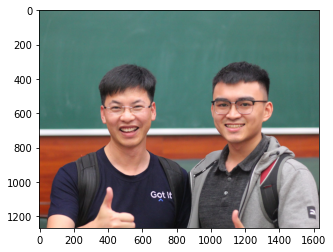

File name:  fb_hieu.jpg
Predicted: Hiếu (0.821398)


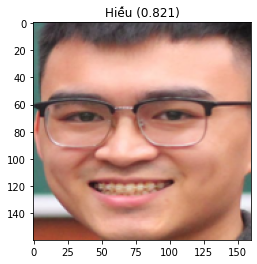

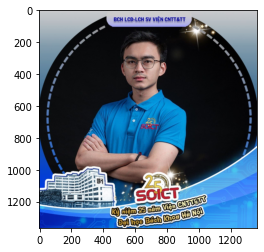

File name:  fb_hieu1.jpg
Predicted: Hiếu (0.961674)


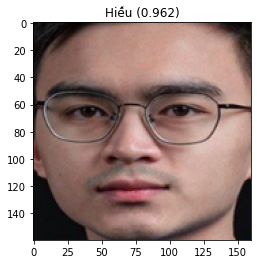

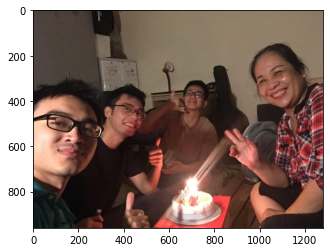

File name:  fb_hieu3.jpg
Predicted: unknown. Closest prediction: Hiếu (0.538659)
None


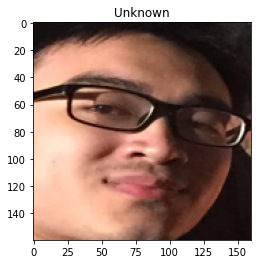

File name:  fb_van1.jpg
Predicted: Vân (0.757902)


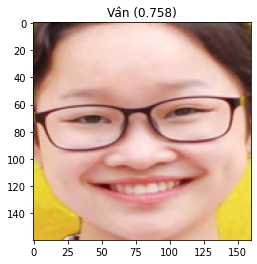

File name:  fb_xuananh2.jpg
Predicted: Xuân Anh (0.976048)


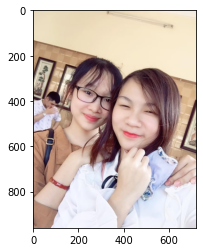

File name:  fb_van2.jpg
Predicted: Vân (0.957023)


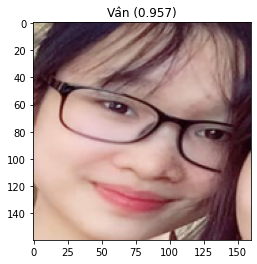

File name:  fb_xuananh3.jpg
Predicted: Xuân Anh (0.957177)


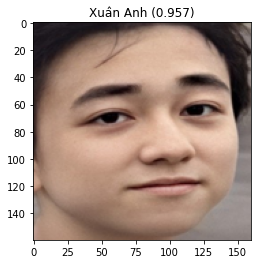

File name:  fb_van4.jpg
Predicted: Vân (0.894675)


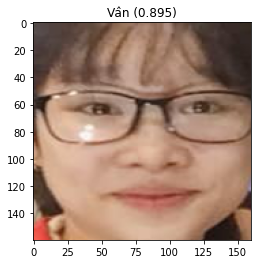

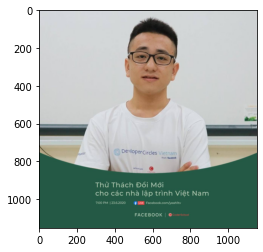

File name:  fb_xuananh1.jpg
Predicted: Xuân Anh (0.953800)


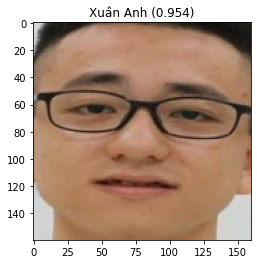

In [ ]:
face_reg_on_folder1('fb_test')